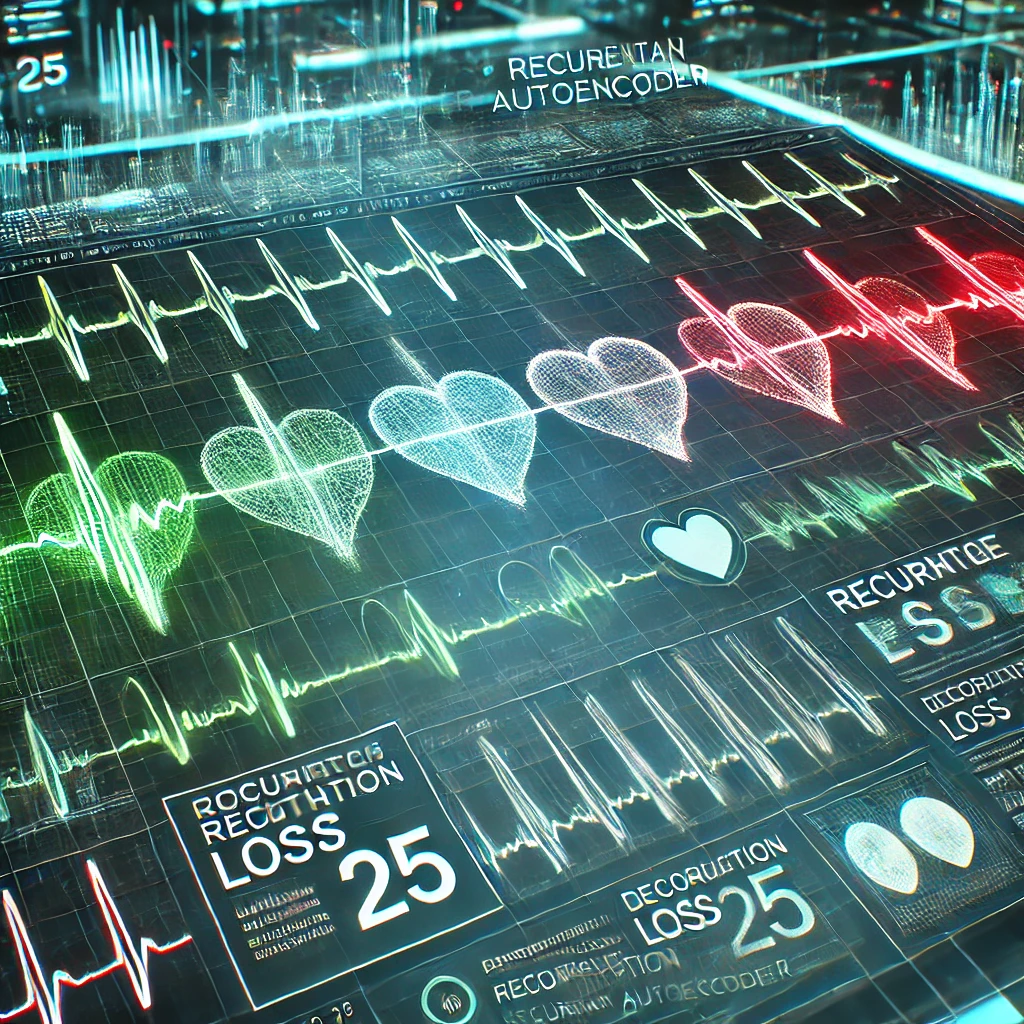

# Analysis of Heart Rhythm Patterns with a Recurrent Autoencoder

In the following task, you will analyze 10 different heart rhythm patterns to determine which are not healthy. The evaluation of heart rhythm data is performed using a pretrained recurrent autoencoder. The autoencoder encodes the input data and then decodes it, deciding whether a pattern is normal or abnormal based on the reconstruction loss between the encoded and decoded patterns. In the pretrained model, reconstruction loss values below 25 indicate a healthy heart rhythm, while values above 25 indicate abnormalities.

## Task Procedure:

1. Load the necessary data.
2. Complete the autoencoder's forward() function and load the model.
3. Perform predictions on the 10 heart rhythm patterns.
4. Based on the loss between the model's encoded and decoded, and the original patterns, determine which pattern may deviate from being healthy. The predefined threshold in the model is 25, which helps determine whether a pattern is healthy or not.

5. **Az eredményeket bináris listában add meg, ahol:**
   - 0: the pattern is healthy
   - 1: the pattern is not healthy

   
   Example: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0] - pay attention to the order of the patterns!



In [1]:
%%capture

!gdown --id 125mhiJ71m-32-1huXmYdCDwGBRMm9ZD4  # Downloads 'ecg_sample_df.pkl'
!gdown --id 1EcX1ONKDuL6Hz52suKu596RDSQY3wagV  # Downloads 'ecg_autoencoder_model.pth'


In [2]:
import seaborn as sns
import numpy as np
import torch
import pandas as pd
from torch import nn, optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
sample_df = pd.read_pickle('ecg_sample_df.pkl')


In [4]:
def create_dataset(df):

    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape

    return dataset, seq_len, n_features

test_dataset, seq_len, n_features = create_dataset(sample_df)


class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))


class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)


class RecurrentAutoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        # Forward pass through the encoder and decoder
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [5]:
# Load the pre-trained model directly
model = torch.load('ecg_autoencoder_model.pth', map_location=device)
model = model.to(device)


<ipython-input-5-338b080ca5bb>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('ecg_autoencoder_model.pth', map_location=device)
/usr/local/lib/python3.1

In [6]:
def predict(model, data, threshold=25):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()

        for seq_true in data:

            # Predict on the ECG samples
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())

    return predictions, losses


In [7]:
predictions, pred_losses = predict(model, test_dataset)

# Determine which samples may be abnormal based on the threshold
threshold = 25
results = [1 if loss > threshold else 0 for loss in pred_losses]
print("Results:", results)


Results: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


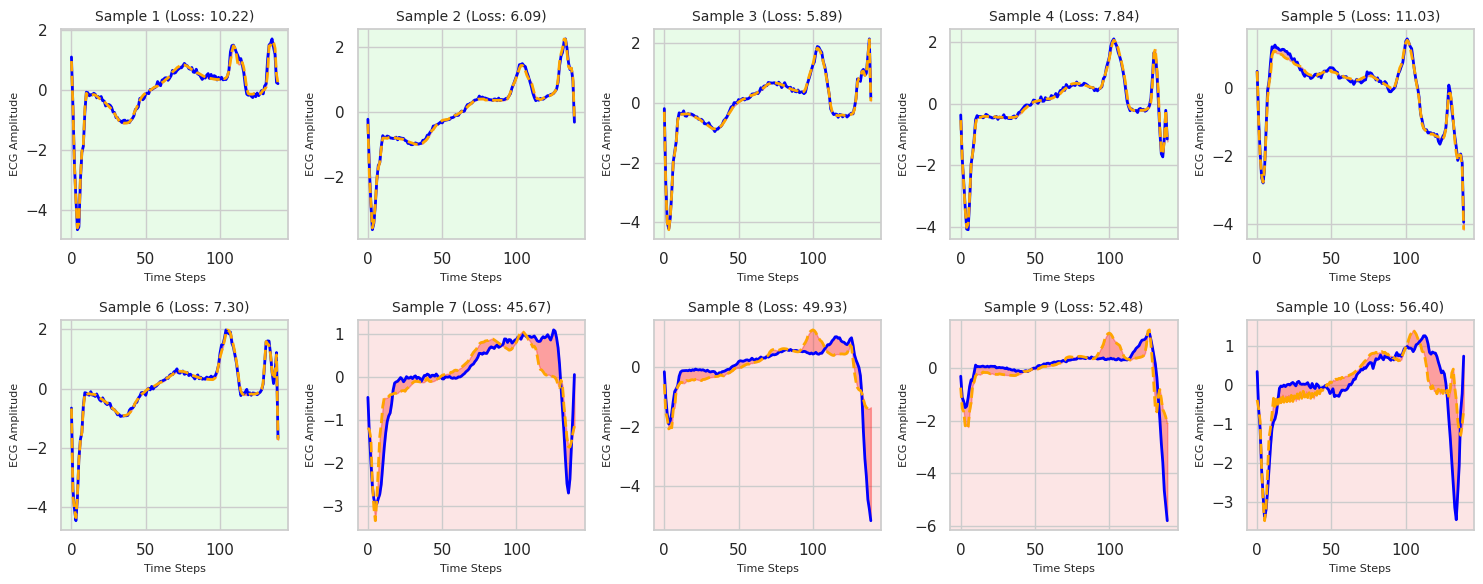

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

criterion = torch.nn.L1Loss(reduction='sum').to('cpu')

def plot_predictions(original, predictions, num_samples=10, grid_size=(2, 5), threshold=25):
    original = np.array([seq.cpu().numpy() for seq in original])
    predictions = np.array(predictions)

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 6))
    axes = axes.flatten()

    for i in range(min(num_samples, grid_size[0] * grid_size[1])):
        original_1d = original[i].flatten()
        predictions_1d = predictions[i].flatten()

        original_tensor = torch.tensor(original_1d).to('cpu')
        predictions_tensor = torch.tensor(predictions_1d).to('cpu')

        loss = criterion(predictions_tensor, original_tensor).item()

        time_steps = np.arange(len(original_1d))

        ax = axes[i]
        ax.plot(time_steps, original_1d, label='Original', color='blue', linewidth=2)
        ax.plot(time_steps, predictions_1d, label='Predicted', color='orange', linestyle='--', linewidth=2)

        ax.fill_between(time_steps, original_1d, predictions_1d,
                        where=original_1d != predictions_1d, color='red', alpha=0.3)

        ax.set_title(f'Sample {i+1} (Loss: {loss:.2f})', fontsize=10)
        ax.set_xlabel('Time Steps', fontsize=8)
        ax.set_ylabel('ECG Amplitude', fontsize=8)

        if loss > threshold:
            ax.set_facecolor('lightcoral')
        else:
            ax.set_facecolor('lightgreen')

        ax.patch.set_alpha(0.2)

    fig.tight_layout()
    plt.show()

# Plot the predictions
plot_predictions(test_dataset, predictions, num_samples=10, grid_size=(2, 5), threshold=25)
